Working with MNIST dataset again
Importing nessesary libraries first

In [3]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model
import keras
from keras import layers
import numpy as np

Importing MNIST

In [11]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Checking data dimensionality

In [9]:
print("Training data shape: ", x_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", x_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


Let's reshape data for convolutional neural network and standardise the values

In [17]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Let's define convolutional autoencoder - we will define encoding part first.

In [30]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded=Flatten()(encoded)

Now let's define decoder part

In [31]:
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
decoded=Reshape((4, 4, 8))(encoded)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Let's now merge encoder and decoder parts together and compile the model with Adam optimiser



In [32]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[7].output)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 8)           0   

And finally, train the model!

In [33]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
469/469 [==============================] - 77s 162ms/step - loss: 0.3161 - val_loss: 0.1443
Epoch 2/5
469/469 [==============================] - 75s 160ms/step - loss: 0.1383 - val_loss: 0.1231
Epoch 3/5
469/469 [==============================] - 75s 160ms/step - loss: 0.1217 - val_loss: 0.1145
Epoch 4/5
469/469 [==============================] - 75s 159ms/step - loss: 0.1150 - val_loss: 0.1105
Epoch 5/5
469/469 [==============================] - 75s 161ms/step - loss: 0.1111 - val_loss: 0.1077


Now we will take two images from our test set

In [47]:
#Image 1
test_image1=x_test[0].reshape(1,28,28,1)
#Image 2
test_image2=x_test[3].reshape(1,28,28,1)
encoded_img1=encoder.predict(test_image1)
encoded_img2=encoder.predict(test_image2)

Now we will have look at the images we chose

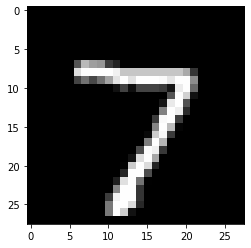

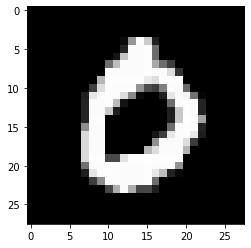

In [48]:
import matplotlib.pyplot as plt
#Display first image
plt.imshow(test_image1.reshape(28, 28))
plt.gray()
plt.show()
#Display second image
plt.imshow(test_image2.reshape(28, 28))
plt.gray()
plt.show()

Now let's define a function which will allows us to interpolate between two vectors

In [37]:
def interpolate_points(p1, p2, n_steps=10): #take two vectors p1 and p2 and create interpolation between them, n-steps define how many intermediate steps to generate
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

And now we are going to interpolate between the original images pixel-wise and between the encodings

In [49]:
interpolated_images=interpolate_points(encoded_img1.flatten(),encoded_img2.flatten())  #interpolations between encodings
interpolated_orig_images=interpolate_points(test_image1.flatten(),test_image2.flatten()) #pixel-wise interpolations

interpolated_images.shape #we can see we got 10 intermediate images

(10, 128)

In [50]:
encoded_input = Input(shape=(128,))

deco = autoencoder.layers[-8](encoded_input)
deco = autoencoder.layers[-7](deco)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 16)        1168

Let's finally visualise results!!

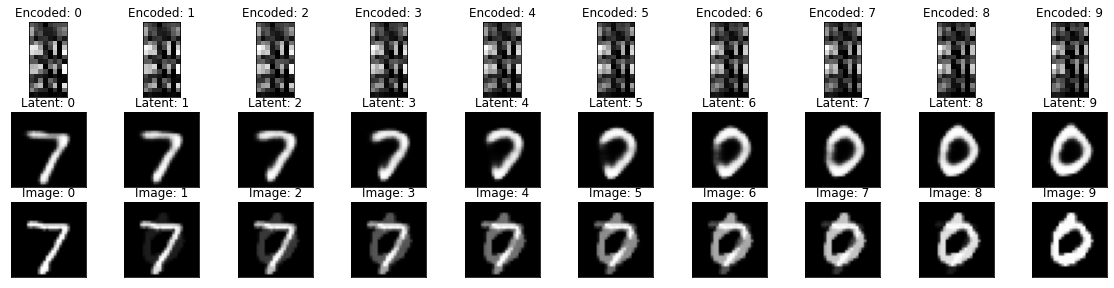

In [51]:
num_images = 10
np.random.seed(42)
plt.figure(figsize=(20, 8))

for i, image_idx in enumerate(interpolated_images):
    
    ax = plt.subplot(5, num_images, i + 1)
    plt.imshow(interpolated_images[i].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Encoded: {}".format(i))
    
    ax = plt.subplot(5, num_images,num_images+ i + 1)
    plt.imshow(decoder.predict(interpolated_images[i].reshape(1,128)).reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Latent: {}".format(i))
    
    ax = plt.subplot(5, num_images,2*num_images+ i + 1)
    plt.imshow(interpolated_orig_images[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Image: {}".format(i))

plt.show()

Try this on Fashion_MNIST

Let's try a different approach called **variational autoencoder**

First, let's create our encoder part, pleaes note, now we are learning mean and standart deviation and not just the bottleneck layer directly

In [36]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2 

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

We will use mean and sigma to sample our hidden layer z from a normal distribution with these parameters. Let's create our sampling function. 

In [37]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

Let's merge together encoder and decoder.

In [38]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

So far, we defined the following:

*   an end-to-end autoencoder mapping inputs to reconstructions
*   an encoder mapping inputs to the latent space
*   a generator that can take points on the latent space and will output the corresponding reconstructed samples

Let's now create a loss function to train our VAE. The loss function is a combination of reconstruction loss and the KL-divergence

In [39]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Now, let's train our model on MNIST data

In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#vae.fit(x_train, x_train,
#        epochs=100,
#        batch_size=32,
#        validation_data=(x_test, x_test))

In [41]:
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 219.1402 - val_loss: 168.3426
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 167.4289 - val_loss: 164.0152
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 163.5550 - val_loss: 161.6984
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 161.2267 - val_loss: 159.8263
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 159.2401 - val_loss: 158.6491
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 157.7365 - val_loss: 157.4102
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 156.8507 - val_loss: 156.4417
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 156.0053 - val_loss: 155.7372
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 154.9641 - val_loss: 155.3071
Epoch 10/10
1875/1875 [=======================

Let's now display latent space for different digits

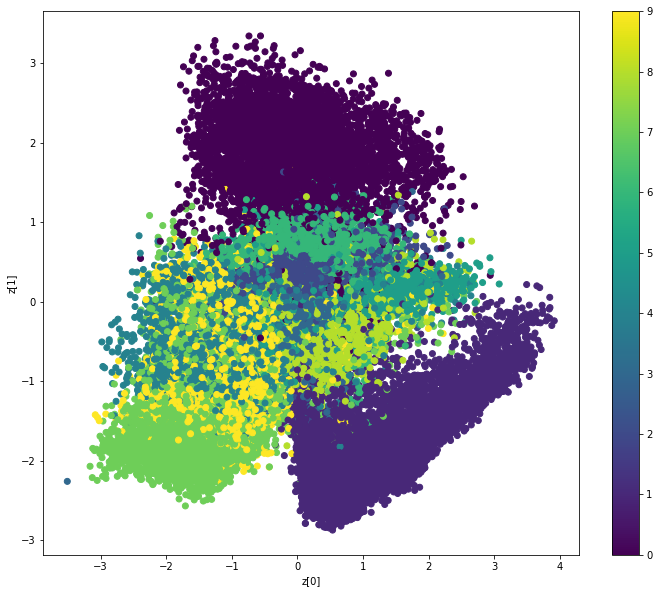

In [42]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

And now let's generate new samples!

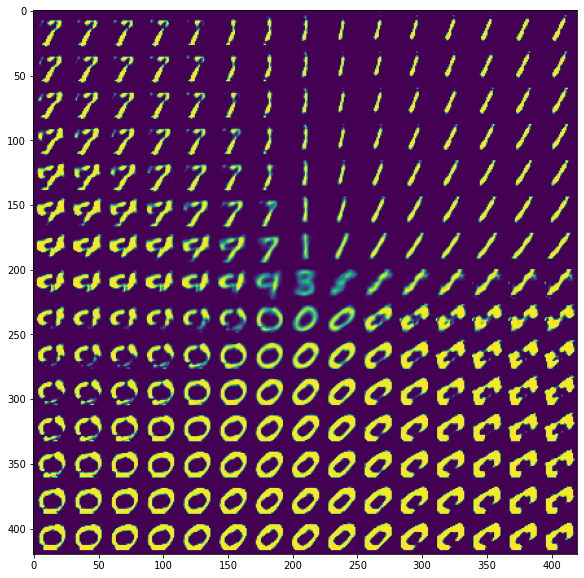

In [44]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()